# Logistic Regression

In [1]:
# load libs
import sys
sys.path.append("../")

import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import math
from logistic_regression import *
from image_recognition import *
from utils import *
from optimize import find_coefficients

In [2]:
# load data
admission_data = pd.read_csv("../data/ex2data1.csv",
                  names=["Exam A", "Exam B", "Admission"])
print(admission_data.head())
print(admission_data.shape)

      Exam A     Exam B  Admission
0  34.623660  78.024693          0
1  30.286711  43.894998          0
2  35.847409  72.902198          0
3  60.182599  86.308552          1
4  79.032736  75.344376          1
(100, 3)


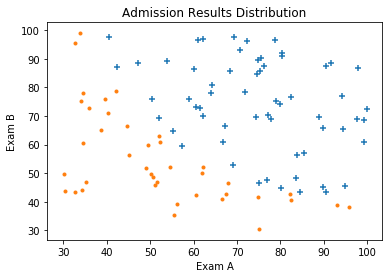

In [3]:
# scatter plot with admitted and not admitted students
def plot_admission_data(show = True):
    admitted = admission_data.loc[admission_data["Admission"] == 1]
    not_admitted = admission_data.loc[admission_data["Admission"] == 0]

    plt.scatter(admitted[["Exam A"]], admitted[["Exam B"]], marker="+")
    plt.scatter(not_admitted[["Exam A"]], not_admitted[["Exam B"]], marker=".")
    plt.xlabel("Exam A")
    plt.ylabel("Exam B")
    plt.title("Admission Results Distribution")
    if show:
        plt.show()
    

plot_admission_data()

## Hypothesis

Split data with logistic function:

$$h(X^{(i)}) = \frac{1}{1 + e^{-z}}$$

Where: 

$$z = \theta_0 x_0^{(i)} + \theta_1 x_1^{(i)} + ... + \theta_n x_n^{(i)} = \Theta^T X^{(i)} $$

$h(X^{(i)})$ ranges from 0 to 1 inclusive, represents probability $P(y = 1)$ of positive outcome.

Positive ($y = 1$) when $h(X^{(i)}) \ge 0.5; z \ge 0$

Negative ($y = 0$) when $h(X^{(i)}) \lt 0.5; z \lt 0$


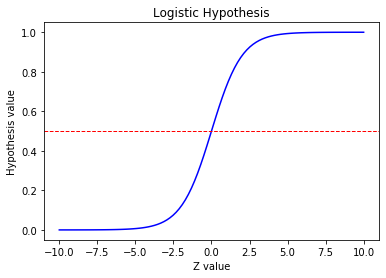

In [4]:
def plot_logistic_hypothesis_function(show = True):
    z = np.linspace(-10, 10, 100)
    h = [sigmoid(val) for val in z]
    plt.plot(z, h, "-b")
    plt.axhline(0.5, color='r', ls="--", lw=1)
    plt.xlabel("Z value")
    plt.ylabel("Hypothesis value")
    plt.title("Logistic Hypothesis")
    if show:
        plt.show()
    

plot_logistic_hypothesis_function()

## Cost Function
Find vector of $\Theta$ parameters which minimize $J(\Theta)$ function:

$$J(\Theta) = - \frac{1}{m} \sum_{i=0}^{m}[ { y^{(i)} log(h(X^{(i)})) 
                       + (1 - y^{(i)}) log(1 - h(X^{(i)})) }]$$

First derivative of the logistic cost function looks simillar to the one in *Linear Regression*:

$$ \theta_j = \theta_j - \alpha \frac{dJ}{d\theta_j} 
            = \theta_j - \alpha \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j $$

## Optimization

Using BFGS algorithm to minimize coefficients. 

In [5]:
# find coefficients using BFGS
x1 = concat_with_x0(admission_data[["Exam A", "Exam B"]])
y1 = admission_data[["Admission"]].values

coefficients = find_coefficients(x1, y1, 
                                 regularized_cost_function, regularized_cost_function_derivative, 0)

print(coefficients)

[-24.99171962   0.20487724   0.2000979 ]


To identify decision boundary with given coefficients, need to solve the following equation:

$h(X^{(i)}) = 0.5$ when $z = 0$, thus $z = \Theta^T X = 0$

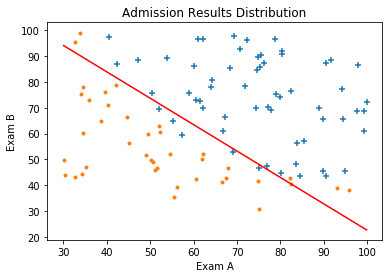

In [6]:
def plot_admission_results_decision_boundary():
    x1_1 = [np.min(admission_data["Exam A"]), np.max(admission_data["Exam A"])]
    x1_2 = [- (coefficients[0] + coefficients[1] * x) / coefficients[2] for x in x1_1]
    plt.plot(x1_1, x1_2, "-r")
    plt.show()
    

plot_admission_data(False)
plot_admission_results_decision_boundary()

# Regularized Logistic Regression

In [7]:
# load data
qa_data = pd.read_csv("../data/ex2data2.csv",
                  names=["Test 1", "Test 2", "QA"])
print(qa_data.head())
print(qa_data.shape)

     Test 1   Test 2  QA
0  0.051267  0.69956   1
1 -0.092742  0.68494   1
2 -0.213710  0.69225   1
3 -0.375000  0.50219   1
4 -0.513250  0.46564   1
(118, 3)


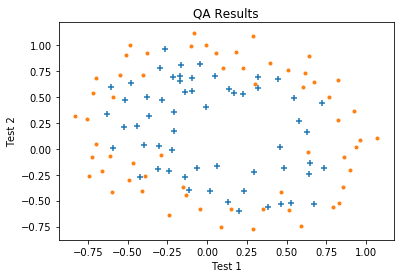

In [8]:
# scatter plot with admitted and not admitted students
def plot_qa_data(show = True):
    passed = qa_data.loc[qa_data["QA"] == 1]
    failed = qa_data.loc[qa_data["QA"] == 0]

    plt.scatter(passed[["Test 1"]], passed[["Test 2"]], marker="+")
    plt.scatter(failed[["Test 1"]], failed[["Test 2"]], marker=".")
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title("QA Results")
    if show:
        plt.show()
    

plot_qa_data()

## Feature Mapping

Linear decision boundary doesn't work in this case. Will introduce feature mapping function to use polynomial features.

$$mapFeatures(x_1, x_2) = \{1, x_1, x_2, x_1^2, x_1 x_2, x_2^2, ..., x_1 x_2^5, x_2^6\}$$

In [9]:
def map_features(x1, x2, degree):
    """
    Map features to polynomial 
    
    @param x1: (m x 1) vector of variable x1 values
    @param x2: (m x 1) vector of variable x2 values
    @param degree: polynomial degree
    @return: (m x N) matrix with N polynomial features
    """
    return np.concatenate([[np.power(x1, i - j) * np.power(x2, j)
     for j in range(i + 1)] 
     for i in range(1, degree + 1)]).transpose()[0]

## Regularized Cost Function

Adding extra parameters sum to the cost function $J(\Theta)$:

$$J_{reg}(\Theta) = J(\Theta) + \frac{\lambda}{2 m} \sum_{j=1}^n \theta_j^2$$

Where $\lambda$ is regularization rate and $\theta_0$ is skipped.

Gradient and first derivative:

$$ \theta_j = \theta_j - \alpha \frac{dJ_{reg}}{d\theta_j} \\
            = \theta_j - \alpha (
                \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j 
                + \frac{\lambda}{m}\theta_j ) \\
            = \theta_j (1 - \frac{\alpha \lambda}{m}) 
                - \alpha \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j $$
                
So $\theta_j$ will be less with each gradient iteration. As the result some features may be considered insignificant.

In [10]:
# find optimal coefficients
polynomial_degree = 6
x2_mapped = map_features(qa_data[["Test 1"]].values, qa_data[["Test 2"]].values, polynomial_degree)
x2_mapped = np.concatenate([np.ones((x2_mapped.shape[0], 1)), x2_mapped], axis=1)
y2 = qa_data[["QA"]].values
regularization_rate = 1

coefficients = find_coefficients(x2_mapped, y2, 
                                 regularized_cost_function, regularized_cost_function_derivative, 
                                 regularization_rate)

print(coefficients)

[ 1.2726322   0.62526851  1.18110054 -2.01977776 -0.91750969 -1.43140105
  0.12396937 -0.36542088 -0.35720348 -0.17516018 -1.45817404 -0.05109747
 -0.61556197 -0.2747374  -1.19275643 -0.24225813 -0.20594332 -0.04478629
 -0.27777193 -0.29534671 -0.45647333 -1.04328679  0.02771439 -0.29243876
  0.01551392 -0.3273817  -0.14391016 -0.92473298]


In [11]:
# calculate model accuracy by comparing model outcomes with original ones 
pred = [sigmoid(x2_mapped @ coefficients) >= 0.5]
print(np.mean(pred == y2.flatten()) * 100)

83.05084745762711


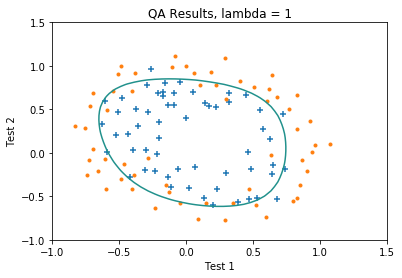

In [12]:
# plot decision boundary
def plot_qa_data_decision_boundary():
    t1 = np.linspace(-1, 1.5, 50)
    t2 = np.linspace(-1, 1.5, 50)

    z = np.array([[coefficients @ \
                   np.concatenate([[1], map_features([t1[i]], [t2[j]], polynomial_degree)])
          for j in range(t2.size)]
         for i in range(t1.size)]).transpose()
    
    plt.contour(t1, t2, z, 0)
    plt.title("QA Results, lambda = " + str(regularization_rate))
    
        
plot_qa_data(False)
plot_qa_data_decision_boundary()
plt.show()

# Image Recognition with Logistic Regression

Using one-vs-all approach to train 10 separate logistic regression classifiers and find the one with:

$$\frac{1}{1 + e^{-\Theta^T X}} \ge 0.5$$

In [13]:
# load and prepare data
def load_data():
    data = scipy.io.loadmat('../data/ex3data1.mat')
    x = data['X']  # m x n^2, where m - experiments count, n - square image size
    y = data['y']  # m x 1 vector of image classes (numbers 0 - 9)

    return x, y

x, y = load_data()

def one_vs_all(y, digit):
    # replace 10 with 0
    return (y == (10 if digit == 0 else digit)).astype(int)

In [14]:
# learn logistic regression coefficients for all digits
def learn(x, y, regularization_rate):
    x = concat_with_x0(x)
    
    return find_coefficients(x, y, 
                             regularized_cost_function, regularized_cost_function_derivative, 
                             regularization_rate, 50)


regularization_rate = 0.1
coefficients = [learn(x, one_vs_all(y, digit), regularization_rate) for digit in range(10)]

In [15]:
# predict images
predictions = [predict(coefficients, image) for image in x]
print_predictions_accuracy(predictions, y)

Prediction accuracy = 89.56%


[6, 0, 3, 1, -1, 0, 9, 7, 1, -1, 7, 1, 5, 0, 4, -1, 2, 3, 2, -1]


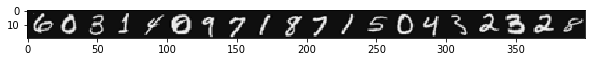

In [16]:
predict_random_images(predictions, x)